# Stanford Core NLP Products

I was introduced to this via the [Understanding language Syntax and structure - A practitioners guide](https://www.kdnuggets.com/2018/08/understanding-language-syntax-and-structure-practitioners-guide-nlp-3.html). My [NLP_2018_ProcessingAndUnderstandingText.ipynb notebook](./NLP_2018_ProcessingAndUnderstandingText.ipynb) explores the code and updates it for 2023.

One of the confusing things about StanfordNLP is that the StanfordNLP group authors toolkits with varying limitations
 - Stanford CoreNLP - _The original java codebase which is offered as a server or used as a jar_. While more complete, this seems to be a _cpu-only_ solution so should be quite slow.
 - StanfordNLP - The python NLP library which has pytorch based _(so much faster)_ `neural pipeline` and provides an client interface to the `CoreNLP`
 - Stanza - Replaces `StanfordNLP`python library.
   - dropped it in 2022 after some analysis as it did not have any CoRef modules. Coref needed calling CoreNLP's java server
   - Thought I'd switch to Spacy since Spacy had HuggingFace's neural CoRef
   - After analyzing Amazon Research's TANL, Oct 2024, turns out Stanza has been updated quite a bit and now has a CoRef release. Revisiting this

## Resources
 - [Stanza Overview](https://stanfordnlp.github.io/stanza/index.html)
 - [Stanza Beginners guide notebook](https://github.com/stanfordnlp/stanza/blob/main/demo/Stanza_Beginners_Guide.ipynb)
 - [Universal Dependencies](https://universaldependencies.org/)

In [5]:
%load_ext nb_js_diagrammers
import iplantuml

Writing output for /home/vamsi/bitbucket/hillops/nbs/NLP/17ef1890-1688-4625-bbc4-2139557c7a2c.uml to 17ef1890-1688-4625-bbc4-2139557c7a2c.svg


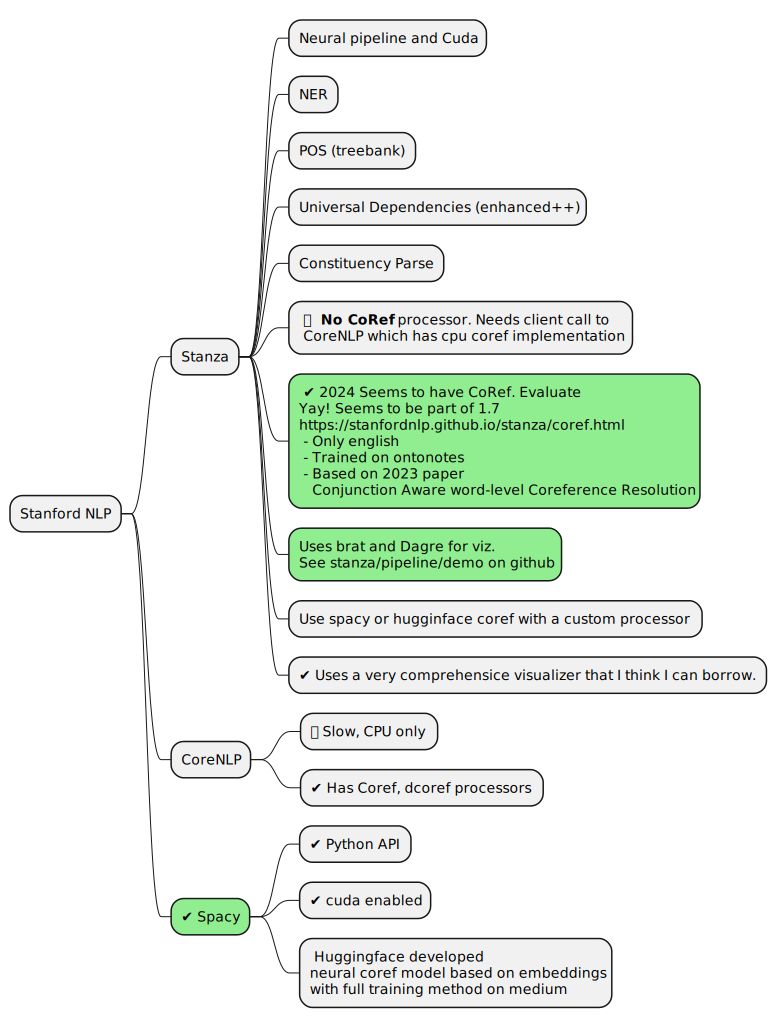

In [15]:
%%plantuml

@startmindmap
* Stanford NLP

** Stanza
*** Neural pipeline and Cuda
*** NER
*** POS (treebank)
*** Universal Dependencies (enhanced++)
*** Constituency Parse
***: --❌  **No CoRef** processor. Needs client call to--
 --CoreNLP which has cpu coref implementation--;
***[#lightgreen]: ✔️ 2024 Seems to have CoRef. Evaluate 
Yay! Seems to be part of 1.7
https://stanfordnlp.github.io/stanza/coref.html
 - Only english
 - Trained on ontonotes
 - Based on 2023 paper 
   Conjunction Aware word-level Coreference Resolution;
***[#lightgreen]:Uses brat and Dagre for viz. 
See stanza/pipeline/demo on github;

*** --Use spacy or hugginface coref with a custom processor-- 
*** ✔️ Uses a very comprehensice visualizer that I think I can borrow.

** CoreNLP
*** ❌ Slow, CPU only
*** ✔️ Has Coref, dcoref processors 

**[#lightgreen] ✔️ Spacy
*** ✔️ Python API
*** ✔️ cuda enabled
***: Huggingface developed
neural coref model based on embeddings
with full training method on medium;
@endmindmap

I am not clear yet about all the NLP needs I have. To animate a story, I certainly need
 - NER
 - POS
 - Enhanced++ Universal dependencies
 - _maybe_ Constituency Parsing
 - Coref Resolution

 ~~While CoRef resolution is slow on the CoreNLP side, it is there and a combination of `Stanza` for most things and `CoreNLP` for coref should be a usable starting point~~ With CoRef in Oct 2024, Stanza should be a fairly complete NLP solution. With UniversalDependencies, it is also a more complete set.

On the other hand, if `SpaCy` has everything I need and has a neural coref model, it should be fast and also an option.

## Stanza-coref

The coref processor is listed in the code but has not made it into their tutorials as of Oct 2024. 
 - Based on a 2023 paper called [CAW-Coref](https://arxiv.org/pdf/2310.06165) which itself fixes a small issue with a 2021 paper [World level Coreference Resolution - Dobrovolskii](https://aclanthology.org/2021.emnlp-main.605.pdf)
   - Single pass on 355M RoBerta-large. 80.7% F1 on Ontonotes
 - Sota seems to be the 2023 paper [Coreference Resolution through a seq2seq Transition-Based System - Bohnet - Google](https://arxiv.org/pdf/2211.12142)
   - Multiple passes on a 13B T5-XXL
   - 83.3% F1 on Ontonotes
   - seq2seq seems TANL adjacent. Need to check out TANL performance in CoRef on ontonotes. _(TANL does not use ontonotes)_
 - Achieves 96% F1 of current SOTA with much more efficiency

# Stanza

## Installation
```console
mamba install -c stanfordnlp stanza
mamba install peft
mamba install nltk
```

 - `peft` is needed when the coref processos is used since the model is a LORA model on RoBerta
 - First time use also requires the download of the language models needed using the following code.

```python
import stanza
stanza.download('en')
```

In [7]:
import json
import stanza
import nltk

In [12]:
import os
from pathlib import Path

stanza_en_dir = Path("~/stanza_resources/en").expanduser()
if not stanza_en_dir.exists():
    # one time download of english language model. There are many other models
    # These are saved under ~/stanza_resources
    #
    # There are some 60+ models.
    # Check https://stanfordnlp.github.io/stanza/models.html for others.
    print("Downloading Stanza english resources and models")
    stanza.download('en')
else:
    print("Stanza english resources and models are already downlaoded")

Stanza english resources and models are already downlaoded



## Tag notation

Looks like between 2018 and 2023, the tagging notation also changed from Penn Treebank notation to [Universal Dependencies](https://universaldependencies.org/). This is quite different from Penn Treebank tags since it wants to apply to multiple languages. Some more resources
 - [MIT article on universal dependencies](https://direct.mit.edu/coli/article/47/2/255/98516/Universal-Dependencies)
 - Reading some old forum articles, there is some confusion between `Universal Dependencies`, `Dependencies`, `Constituency Parsing` and such.
   - 2023 atleast, for each parsed sentence
     - `constituency` tree is avaiable. See [Stanza Constituency Parser](https://stanfordnlp.github.io/stanza/constituency.html)
     - `dependency` shows the basic set of 37 universal dependencies. There is some extra work needed to get to the `enhanced++` dependencies


## Basic Parse

Setup the pipeline and invoke it.

### Setting up the pipeline

The simplest way of setting up the pipeline is to specify only the language: `nlp = stanza.Pipeline('en')`. This uses a default set of processors which are listed in the output. _See the output of the cell below_. These are 
 - tokenize
 - pos
 - lemma
 - constituency
 - depparse
 - sentiment
 - ner

 To specify the list of processors, see [stanza processor availability](https://stanfordnlp.github.io/stanza/pipeline.html#processors), keep in mind that some processors need others and such dependencies should be listed earlier and invoke in this fashion

 `nlp = stanza.Pipeline('de', processors='tokenize,mwt', package='gsd')`

 See [Stanza Getting Started](https://stanfordnlp.github.io/stanza/getting_started.html) for more info.

### Annotating the document

Annotation is as simple as simply passing a string into the pipeline. This runs all the specified _(or default)_ processors on the input and returns annotation information in the returned structure.

In [13]:
import stanza
stanza_nlp = stanza.Pipeline('en')  # Setup a neural pipeline in english
doc = stanza_nlp("Barack Obama is the president of the United States")
doc.sentences[0].print_dependencies()

2024-10-09 21:05:15 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-10-09 21:05:15 INFO: Downloaded file to /home/vamsi/stanza_resources/resources.json
2024-10-09 21:05:16 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2024-10-09 21:05:16 INFO: Using device: cuda
2024-10-09 21:05:16 INFO: Loading: tokenize
/home/vamsi/mambaforge/envs/ml/lib/python3.12/site-packages/stanza/models/tokenization/trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle dat

('Barack', 5, 'nsubj')
('Obama', 1, 'flat')
('is', 5, 'cop')
('the', 5, 'det')
('president', 0, 'root')
('of', 9, 'case')
('the', 9, 'det')
('United', 9, 'amod')
('States', 5, 'nmod')


## Stanza API study

Some notable methods from the Help on the sentence object. Sentence is obtained by `doc.sentences[0]`
 - print_dependencies()
 - print_tokens()
 - print_words()
 - to_dict()
 - constituency
 - dependencies
 - entities/ents
 - sentiment
 

## Constituency Parse tree

In [16]:
# Can print out the constituency graph. Phrase structure Parser
print(doc.sentences[0].constituency.pretty_print())

(ROOT
  (S
    (NP (NNP Barack) (NNP Obama))
    (VP
      (VBZ is)
      (NP
        (NP (DT the) (NN president))
        (PP
          (IN of)
          (NP (DT the) (NNP United) (NNPS States)))))))



## Print out entire parse tree

In [17]:
# Entire parse as a dict
# UPOS   : Universal POS tag
# XPOS   : Treebank-specific tag
# UFeats : Universal morphological features
# head   : syntactic head
# deprel : 
import json
print(
    json.dumps(doc.sentences[0].to_dict(), sort_keys=True, indent=4)
)

[
    {
        "deprel": "nsubj",
        "end_char": 6,
        "feats": "Number=Sing",
        "head": 5,
        "id": 1,
        "lemma": "Barack",
        "multi_ner": [
            "B-PERSON"
        ],
        "ner": "B-PERSON",
        "start_char": 0,
        "text": "Barack",
        "upos": "PROPN",
        "xpos": "NNP"
    },
    {
        "deprel": "flat",
        "end_char": 12,
        "feats": "Number=Sing",
        "head": 1,
        "id": 2,
        "lemma": "Obama",
        "multi_ner": [
            "E-PERSON"
        ],
        "ner": "E-PERSON",
        "start_char": 7,
        "text": "Obama",
        "upos": "PROPN",
        "xpos": "NNP"
    },
    {
        "deprel": "cop",
        "end_char": 15,
        "feats": "Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin",
        "head": 5,
        "id": 3,
        "lemma": "be",
        "multi_ner": [
            "O"
        ],
        "ner": "O",
        "start_char": 13,
        "text": "is",
        "upos"

## Print sentiment analysis annotation

In [18]:
# 0 - Negative
# 1 - Neutral
# 2 - Positive
print(
    doc.sentences[0].sentiment
)

1


## Display the constituency tree

The toolslisted in Dipanjan's articles use `nltk` tree display. However, it is fairly easy to transform the stanford tree into nltk tree for display. Note that stanza has one or more visualizers as part of their demo server. No idea how to get them into jupyter tho.

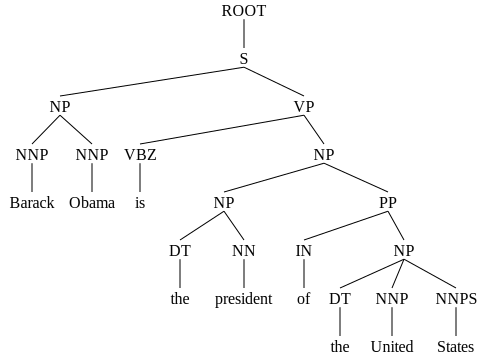

In [19]:
from nltk.tree import Tree

display(Tree.fromstring(str(doc.sentences[0].constituency)))

## Stanza Coreference resolution


While the docs and tutorials do not reference `coref`, github shows a `coref_processor`. Seems to work.

On further digging tho, [spacy coref](https://explosion.ai/blog/coref) has a beautiful long blog post
 - They use the same Dobsroskii paper
 - Lot more future direction work.
 - Existing pipeline ready to use

Stanza seems like a research project that is barely supported. Spacy would be much more commercially viable and way better documented.

In [18]:
# Coref dowloads the uccoref LORA on a roberta-large 2.24G in size!
import stanza
stanza_nlp = stanza.Pipeline('en', processors='tokenize,pos,coref')
doc = stanza_nlp("Barack Obama is the president of the United States. He is a great guy!")
doc.sentences[0].print_dependencies()

2024-10-09 21:25:48 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-10-09 21:25:49 INFO: Downloaded file to /home/vamsi/stanza_resources/resources.json
2024-10-09 21:25:49 WARNING: Language en package default expects mwt, which has been added
2024-10-09 21:25:49 INFO: Loading these models for language: en (English):
| Processor | Package                  |
----------------------------------------
| tokenize  | combined                 |
| mwt       | combined                 |
| pos       | combined_charlm          |
| coref     | udcoref_xlm-roberta-lora |

2024-10-09 21:25:49 INFO: Using device: cuda
2024-10-09 21:25:49 INFO: Loading: tokenize
/home/vamsi/mambaforge/envs/ml/lib/python3.12/site-packages/stanza/models/tokenization/trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.

In [28]:
# Without a proper example
# I am looking at https://github.com/stanfordnlp/stanza/blob/main/stanza/pipeline/coref_processor.py
# doc.coref: List[CorefChain]
dir(doc.coref)
for sentence in doc.sentences:
    print(sentence)

[
  {
    "id": 1,
    "text": "Barack",
    "upos": "PROPN",
    "xpos": "NNP",
    "feats": "Number=Sing",
    "start_char": 0,
    "end_char": 6,
    "coref_chains": [
      {
        "index": 0,
        "representative_text": "the president of the United States",
        "is_start": true
      }
    ]
  },
  {
    "id": 2,
    "text": "Obama",
    "upos": "PROPN",
    "xpos": "NNP",
    "feats": "Number=Sing",
    "start_char": 7,
    "end_char": 12,
    "coref_chains": [
      {
        "index": 0,
        "representative_text": "the president of the United States",
        "is_end": true
      }
    ]
  },
  {
    "id": 3,
    "text": "is",
    "upos": "AUX",
    "xpos": "VBZ",
    "feats": "Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin",
    "start_char": 13,
    "end_char": 15,
    "coref_chains": []
  },
  {
    "id": 4,
    "text": "the",
    "upos": "DET",
    "xpos": "DT",
    "feats": "Definite=Def|PronType=Art",
    "start_char": 16,
    "end_char": 19,
    "coref


## Stanza dependencies

> Anything beyond the standard dependencies needs Java and the coreNLP package to be installed
>
> use `stanza.install_corenlp()` which installs it into `~/stanza_corenlp`

The Stanza Python API by default only supports `standard Universal Dependencies`. The CoreNLP server product _(java)_ however supports multiple types of universal dependencies (all through the same `depparse` module that is used by stanza)
 - BasicDependenciesAnnotation
   - _(aka basic)_ - just the 37 standard UD dependencies
   - Easy to parse, small set
 - EnhancedDependenciesAnnotation : _(aka enhanced)_
   - From the JSON response, this is **likely** available under the `sentence[enhancedDependencies]` key.
 - EnhancedPlusPlusDependenciesAnnotation : _(aka enhanced++)_
   - From the JSON response, this is available under the `sentence[enhancedPlusPlusDependencies]` key.
   - I heard about this from [coreNLP Dtree Visualizer](https://github.com/doug919/corenlp_dtree_visualizer) which converts the CoreNLP dependency tree into a format that can be visualized by spacy!.
   - Deterministic transformations on the basic dependencies
   - Lot more semantic information

```python
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,lemma,depparse')
with ud_enhancer.UniversalEnhancer(language="en") as enhancer:
    depparseFromStanza = nlp("This is a test")
    depparseEnhanced = enhancer.process(depparseFromStanza)
)
```

### Stanza basic dependencies

These are part of the 37 basic universal dependency relations. Meant to be 
 - concise
 - easy to parse

In [20]:
doc.sentences[0].print_dependencies()

('Barack', 5, 'nsubj')
('Obama', 1, 'flat')
('is', 5, 'cop')
('the', 5, 'det')
('president', 0, 'root')
('of', 9, 'case')
('the', 9, 'det')
('United', 9, 'amod')
('States', 5, 'nmod')


## Stanza enhanced dependencies

EnhancedDependencies were created to fix weaknesses in basic dependencies _(maybe for some languages or for english itself)_. However, apparently even these were not enough and eventually the world got _enhanced++Dependencies__ which is what everyone seems to use now _(judging from examples)_

This is implemented as an enhancer on top of the basic dependencies and for stanza, this requires the use of the CoreNLP java package via stanza. use `stanza.install_corenlp()` to install it from within jupyter or python repl. Two ways of invoking it.

In [24]:
# Note that stanza.install_corenlp() installs it into ~/stanza_corenlp
import os
os.environ["CORENLP_HOME"] = "/home/vamsi/stanza_corenlp"

# Ref: https://github.com/stanfordnlp/stanza/issues/359
# To get enhanced stanza dependencies. This is one way
# Needs the StanfordCoreNLP java process to be running
import stanza.server.ud_enhancer as ud_enhancer
ud_enhancer.process_doc(doc, language="en")

ValueError: Classpath is None,  Perhaps you need to set the $CLASSPATH or $CORENLP_HOME environment variable to point to a CoreNLP install.

In [26]:
import stanza.server.ud_enhancer as ud_enhancer

# Ref: https://github.com/stanfordnlp/stanza/issues/359
enh_ud_nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,lemma,depparse')
with ud_enhancer.UniversalEnhancer(language="en") as enhancer:
    depparseFromStanza = enh_ud_nlp("John said that he loved mila")
    depparseEnhanced = enhancer.process(depparseFromStanza)

# This gets the enhancedPlusPludDependencies
depparseEnhanced.sentence[0].enhancedPlusPlusDependencies

2023-06-11 23:30:24 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-06-11 23:30:25 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2023-06-11 23:30:25 INFO: Using device: cuda
2023-06-11 23:30:25 INFO: Loading: tokenize
2023-06-11 23:30:25 INFO: Loading: pos
2023-06-11 23:30:25 INFO: Loading: lemma
2023-06-11 23:30:25 INFO: Loading: depparse
2023-06-11 23:30:25 INFO: Done loading processors!


node {
  sentenceIndex: 0
  index: 1
}
node {
  sentenceIndex: 0
  index: 2
}
node {
  sentenceIndex: 0
  index: 3
}
node {
  sentenceIndex: 0
  index: 4
}
node {
  sentenceIndex: 0
  index: 5
}
node {
  sentenceIndex: 0
  index: 6
}
edge {
  source: 2
  target: 1
  dep: "nsubj"
  isExtra: false
  sourceCopy: 0
  targetCopy: 0
  language: UniversalEnglish
}
edge {
  source: 2
  target: 5
  dep: "ccomp"
  isExtra: false
  sourceCopy: 0
  targetCopy: 0
  language: UniversalEnglish
}
edge {
  source: 5
  target: 3
  dep: "mark"
  isExtra: false
  sourceCopy: 0
  targetCopy: 0
  language: UniversalEnglish
}
edge {
  source: 5
  target: 4
  dep: "nsubj"
  isExtra: false
  sourceCopy: 0
  targetCopy: 0
  language: UniversalEnglish
}
edge {
  source: 5
  target: 6
  dep: "obj"
  isExtra: false
  sourceCopy: 0
  targetCopy: 0
  language: UniversalEnglish
}
root: 2

### Visualize enhanced dependencies 

> A lot more information about visualization at [NLP_AnnotationRendering.ipynb](./NLP_AnnotationRendering.ipynb)



## Query stanza resources

Includes the names of processors, models etc.

In [7]:
from stanza.resources.common import load_resources_json

def print_stanza_resources_for_lang(lang):
    resources = load_resources_json()
    if lang in resources:
        print( json.dumps(resources[lang], sort_keys=True, indent=4))
    else:
        print(f"No such language: {lang}")
    
print_stanza_resources_for_lang('en')

{
    "backward_charlm": {
        "1billion": {
            "md5": "1405948b125b4264fd17509d1b6175ca"
        },
        "mimic": {
            "md5": "19a16ba4b8526e54ef8ab21ca33cc423"
        },
        "pubmed": {
            "md5": "f2c42f6b2f7205d2b254d6ab0fb13303"
        }
    },
    "constituency": {
        "ptb3_bert": {
            "dependencies": [
                {
                    "model": "pretrain",
                    "package": "combined"
                },
                {
                    "model": "forward_charlm",
                    "package": "1billion"
                },
                {
                    "model": "backward_charlm",
                    "package": "1billion"
                }
            ],
            "md5": "dbfddfd4174f838e50426e6d04c4ccbd"
        },
        "wsj": {
            "dependencies": [
                {
                    "model": "pretrain",
                    "package": "combined"
                },
                {